In [1]:
import cx_Oracle
import os
import pandas as pd
#!pip insall cx_Oracle

In [2]:
import xlwings as xw
import pandas as pd
wb_cy = xw.Book('cytiva.xlsm')
SHEET_NAMES =  ['Temp_DB', 'Shipment information', '인수증', 
'대리점송장', '대리점 출고대기', '로컬리스트', 'In-Transit part report', '기타리스트',
 '출고리스트', 'Cytiva Inventory BIN']

In [3]:
LOCATION = r"C:\Users\lms46\Desktop\fulfill\instantclient_fulfill"
os.environ["PATH"] = LOCATION + ";" + os.environ["PATH"]
cx_Oracle.init_oracle_client(lib_dir=LOCATION)

connection = cx_Oracle.connect(
    user='dw_fulfill', password='fulfillment123QWE!@#', dsn='fulfill_high'

)
cursor = connection.cursor()

In [4]:
connection = cx_Oracle.connect(
    user='dw_fulfill', password='fulfillment123QWE!@#', dsn='fulfill_high'

)
cursor = connection.cursor()

In [10]:
import json

ML_INDEX	REQ_TYPE	MAIL_DATE	REQ_DATE	PIC	IS_URGENT	LEFT_TIME	STATUS	PRINT	SHIP_CONFIRM
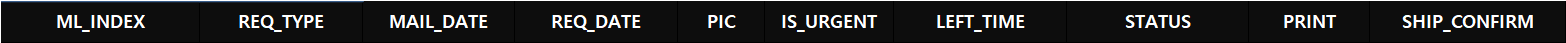

- 원하는 조건에 맞는 요청리스트 불러오기는 다른 방식으로 해결해야지.. json으로 정렬해서 채울것


In [481]:
def bring_reuests():

    sel_sth = wb_cy.selection.sheet
    form_add = ['$M$7:$M$9', '$O$7']
    qry_condition = sel_sth.range(form_add[0]).options(ndim=1).value + sel_sth.range(form_add[1]).options(ndim=1).value
    STATUS = ['requested', 'pick/pack', 'dispathed', 'completed']
    col_list =['ML_INDEX','REQ_TYPE','CREATE_DATE','REQ_DATE','PIC','IS_URGENT','LEFT_TIME','STATUS','DEL_MED','REGION']
    base_qry = 'select * from SERVICE_REQEUST '
    json_data = []


    # 시작하기전에 sht 클리닝
    last_row = sel_sth.range("J1048576").end('up').row
    if last_row < 12 :
        last_row = 12
    req_rng = sel_sth.range((12,"I"),(last_row,"S"))
    req_rng.clear_contents()
    req_rng.color= None
    selected_cel = sel_sth.range("Q8")
    selected_cel.clear_contents()

    # REQ_TYPE
    if qry_condition[2] == 'ALL' :
        qry = base_qry
    else :
        qry = base_qry + f'WHERE svc_key LIKE \'%{qry_condition[2]}%\' '

    # STATUS
    if qry_condition[3] == 'ALL' :
        qry = qry
    else:
        qry = qry + "AND STATE = " +  f"'{qry_condition[3]}'"

    df_req = pd.DataFrame(cursor.execute(qry))
    for i in df_req:
        row_req = df_req.loc[i]

        rows = []
        # ML_INDEX
        rows.append(row_req[0])
        # REQ_TYPE
        rows.append(row_req[0].split("_")[0])
        # CREATE_DATE
        req_tl = json.loads(row_req[15])['data']
        for tl in req_tl :
            if tl['a'] == 'create' :
                rows.append(tl['c'])
        # REQ_DATE
        req_date = row_req[3] + " "+ row_req[4]
        rows.append(req_date)
        # PIC
        rows.append(row_req[1])
        # IS_URGENT
        rows.append(row_req[8])
        # LEFT_TIME
        now = str(dt.datetime.now()).split('.')[0]
        now_obj = dt.datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
        req_date_obj = dt.datetime.strptime(req_date, '%Y-%m-%d %H:%M')
        cal_time = req_date_obj-now_obj

        rows.append(cal_time.days*24 +cal_time.seconds//60)

        # STATUS 
        rows.append(row_req[16])


        # DEL_MED
        rows.append(row_req[6])

        # REGION
        tmp_sp = row_req[5].split(" ")
        region = tmp_sp[0]+" " + tmp_sp[1]
        rows.append(region)


        tmp = dict(zip(col_list,rows))
        json_data.append(tmp)

    df_fin = pd.DataFrame(json_data)
    # from_to
    if qry_condition[0] == None:
        qry_condition[0] = dt.datetime(1999, 1, 1)
    if qry_condition[1] == None:
        qry_condition[1] = dt.datetime(2199, 1, 1)

    df_fin['CREATE_DATE'] = df_fin['CREATE_DATE'].astype('datetime64[ns]')
    df_fin = df_fin[df_fin['CREATE_DATE'].between(str(qry_condition[0]),str(qry_condition[1]))]
    df_fin.reset_index(drop=True,inplace=True)
    df_fin.index = df_fin.index +1
    sel_sth.range('I11').value = df_fin

    # # 
    last_row = sel_sth.range("J1048576").end('up').row
    if last_row < 12 :
        last_row = 12
    req_rng = sel_sth.range((12,"I"),(last_row,"S"))
    req_rng.color = (253, 233, 217)
    req_rng.font.bold = True



In [456]:
bring_reuests()

In [434]:
# 각 요청 다루기

(253, 233, 217)

In [485]:
# 행 선택기능

def select_reqeust():
    sel_sth = wb_cy.selection.sheet
    selected_cel = sel_sth.range("Q8")
    last_row = sel_sth.range("J1048576").end('up').row
    if last_row < 12 :
        last_row = 12
    req_rng = sel_sth.range((12,"I"),(last_row,"S"))
    req_rng

    sel_cel = wb_cy.selection.address
    cel_row = wb_cy.selection.row
    idx_cel_val = sel_sth.range(sel_cel).value
    if ':' in sel_cel or ',' in sel_cel :  
        wb_cy.app.alert("ML_INDEX 컬럼에서 원하는 한 개의 셀만 선택해주세요")
        return None
    if "J" not in sel_cel : 
        wb_cy.app.alert("ML_INDEX 컬럼에서 원하는 한 개의 셀만 선택해주세요")
        return None
    if cel_row < 12 : 
        wb_cy.app.alert("ML_INDEX 컬럼에서 값이 있는 선택해주세요")
        return None
    if idx_cel_val == None : 
        wb_cy.app.alert("ML_INDEX 컬럼에서 값이 있는 선택해주세요")
        return None

    selected_cel.value = idx_cel_val


In [501]:
select_reqeust()

In [520]:
## 메일열기
def oepn_mail():
    sel_sth = wb_cy.selection.sheet
    selected_cel = sel_sth.range("Q8")
    if selected_cel.value == None:
        wb_cy.app.alert("선택한 요청이 없습니다. 매서드를 종료합니다.")
        return None

    req_type = selected_cel.value.split('_')[0]
    import win32com.client as cli
    outlook = cli.Dispatch("Outlook.Application").GetNamespace("MAPI") # 아웃룩
    msg_list = outlook.GetDefaultFolder(6).Parent.Folders(req_type).Items
    
    for ms in msg_list:
        if ms.Subject == selected_cel.value:
            ms.Display()

In [521]:
oepn_mail()

In [ ]:
def print_svc():
    col_list =['ML_INDEX','REQ_TYPE','CREATE_DATE','REQ_DATE','PIC','IS_URGENT','LEFT_TIME',
               'STATUS','DEL_MED','ADDRESS','IS_RETURN','RECIPIENT', 'DEL_INSTRUCTION','CONTACT','PARTS']
    sel_sth = wb_cy.selection.sheet
    selected_cel = sel_sth.range("Q8")
    svc_key = selected_cel.value
    qry = base_qry + 'where svc_key =' +  f"'{svc_key}'"
    sel_data = pd.DataFrame([cursor.execute(qry).fetchone()])
    sel_data.loc[0]
    
    json_data=[]
    row_req = sel_data.loc[0]

    rows = []
    # ML_INDEX
    rows.append(row_req[0])
    # REQ_TYPE
    rows.append(row_req[0].split("_")[0])
    # CREATE_DATE
    req_tl = json.loads(row_req[15])['data']
    for tl in req_tl :
        if tl['a'] == 'create' :
            rows.append(tl['c'])
    # REQ_DATE
    req_date = row_req[3] + " "+ row_req[4]
    rows.append(req_date)
    # PIC
    rows.append(row_req[1])
    # IS_URGENT
    rows.append(row_req[8])
    # LEFT_TIME
    now = str(dt.datetime.now()).split('.')[0]
    now_obj = dt.datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
    req_date_obj = dt.datetime.strptime(req_date, '%Y-%m-%d %H:%M')
    cal_time = req_date_obj-now_obj

    rows.append(cal_time.days*24 +cal_time.seconds//60)

    # STATUS 
    rows.append(row_req[16])


    # DEL_MED
    rows.append(row_req[6])

    # ADDRESS
    rows.append(row_req[5])

    # IS_RETURN 7
    rows.append(row_req[7])
    # RECIPIENT 9
    rows.append(row_req[9])
    # DEL_INSTRUCTION 12
    rows.append(row_req[12])
    # CONTACT  10
    rows.append(row_req[10])
    # PARTS
    parts_dict = json.loads(row_req[13].replace("'",'"'))
    df_parts = pd.DataFrame(parts_dict)
    df_parts.index = df_parts.index+1
    rows.append(df_parts)

    tmp = dict(zip(col_list,rows))
    json_data.append(tmp)

    df_fin = pd.DataFrame(json_data)
    
    print_form_dir = "C:\\Users\\lms46\\Desktop\\fulfill\\xlwings_job\\print_form.xlsx"
    try:
        ws_svc= xw.Book('print_form.xlsx').sheets['SVC']
    except :
        ws_svc= xw.Book(print_form_dir).sheets['SVC']

    ws_svc.range('B21:H40').clear_contents()

    ws_svc.range('E2').value = df_fin.loc[0]['ML_INDEX']
        # Printed Day E3
    ws_svc.range('E3').value = get_current_time()
        # Delievery Type E5
    ws_svc.range('E5').value = df_fin.loc[0]['DEL_MED']

    is_return = None

    if is_return != None:
        is_return = '왕복'

        # Recipient B6
    ws_svc.range('B6').value = df_fin.loc[0]['RECIPIENT']
        # Contact E6
    ws_svc.range('E6').value = df_fin.loc[0]['CONTACT']
        # Request day A10
    ws_svc.range('A10').value  = df_fin.loc[0]['REQ_DATE']
        # IS_RETURN A11
    ws_svc.range('A11').value  = df_fin.loc[0]['IS_RETURN']
        # Address D10
    ws_svc.range('D10').value = df_fin.loc[0]['ADDRESS']
        # Deilevery Instructions A14
    ws_svc.range('A14').value = df_fin.loc[0]['DEL_INSTRUCTION']
        # parts_info A20
    ws_svc.range('A20').value = df_fin.loc[0]['PARTS']
        # Depart From B41
    ws_svc.range('B41').value = '서울시 강서구 하늘길 247 3층 C구역'
        # TEL B42
    ws_svc.range('B42').value = '02-2660-3767'
        # Phone B43
    ws_svc.range('B43').value = '담당자 폰번호'
        # URGENT E41
    is_urgent = df_fin.loc[0]['IS_URGENT']
    if is_urgent != None:
        is_urgent = '긴급' 

    ws_svc.range('E41').value = is_urgent

    # 바코드 생성
    pic = save_barcode_loc(shape_name)
    top = ws_svc.range('E41').top
    left = ws_svc.range('E41').left
    ws_svc.pictures.add(pic, name='barcode',update=True,
                        top=top,left=left,scale=0.55)
    os.remove(pic)
    ws_svc.pictures[-1].lock_aspect_ratio =False
    ws_svc.pictures[-1].width = 262
    ws_svc.pictures[-1].height = 51

In [622]:
STATUS[1]

'pick/pack'

In [624]:
json.dumps(up_time_content,ensure_ascii=False)

'[{"a": "create", "b": "0", "c": "2023-02-22 15:32:38"}]'

In [631]:
req_tl = pd.DataFrame([cursor.execute(qry).fetchone()])[15][0]
sel_sth = wb_cy.selection.sheet
selected_cel = sel_sth.range("Q8")
svc_key = selected_cel.value
up_time_content = req_tl
req_tl


'{"meta": {"desc": "data_update_timeline", "cols": {"a": "db_method", "b": "count", "c": "timeline"}}, "data": [{"a": "create", "b": "0", "c": "2023-02-22 15:32:38"}]}'

In [632]:
js_test = '{"meta": {"desc": "data_update_timeline", "cols": {"a": "db_method", "b": "count", "c": "timeline"}}, "data": [{"a": "create", "b": "0", "c": "2023-02-22 13:20:17"}, {"a": "update", "b": "1", "c": "2023-02-25 17:28:02"}]}'

In [634]:
json.loads(js_test)['data']

[{'a': 'create', 'b': '0', 'c': '2023-02-22 13:20:17'},
 {'a': 'update', 'b': '1', 'c': '2023-02-25 17:28:02'}]

In [643]:
req_tl = pd.DataFrame([cursor.execute(qry).fetchone()])[16][0]
req_tl

'requested'

In [638]:
selected_cel = self.SEL_STH.range("Q8")
if selected_cel.value == None:
    wb_cy.app.alert("선택한 요청이 없습니다. 매서드를 종료합니다.",'Quit')
    return None
req_confirm = wb_cy.app.alert('출고하시겠습니까? STATUS는 dispatched로 변경됩니다.','Ship Confirm Request',buttons ='yes_no_cancel')
if req_confirm != 'yes':
    wb_cy.app.alert('종료합니다.','Quit')
    return None

'no'

In [ ]:
# SHIP_CONFIRM dispathed
selected_cel = sel_sth.range("Q8")
svc_key = selected_cel.value
qry = self.BASE_QRY + 'where svc_key =' +  f"'{svc_key}'"
up_time_content = pd.DataFrame([DataWarehouse().execute(qry).fetchone()])[15][0]
status = self.STATUS[2] # dispatched


# ServiceRequest.update_status(svc_key,up_time_content,status)

In [666]:
print(os.path.abspath('.'))

C:\Users\lms46\Desktop\fulfill\jp


In [672]:
print(f'__file__ : {__file__}')

NameError: name '__file__' is not defined

In [671]:
path = os.path.dirname(os.path.abspath(__file__)) 
print(path)

NameError: name '__file__' is not defined

In [27]:
19793
19794
20454
20490

20490

In [31]:
json_tl = pd.DataFrame(cursor.execute("SELECT TIMELINE FROM SHIPMENT_INFORMATION WHERE SI_INDEX = 20490").fetchone())[0][0]
json_tl

KeyError: 0

In [44]:
json_tl = cursor.execute("SELECT TIMELINE FROM SHIPMENT_INFORMATION WHERE SI_INDEX = 19783").fetchone()[0]
json_tl

'{"meta": {"desc": "data_update_timeline", "cols": {"a": "db_method", "b": "count", "c": "timeline"}}, "data": [{"a": "create", "b": "0", "c": "2023-02-16 11:05:27"}]}'

In [45]:
import datetime as dt

In [46]:
import json
data=[]
cols=['a','b','c']
load_json = json.loads(json_tl)['data']
load_json
update_count=len(load_json)
rows=[]
now = str(dt.datetime.now()).split('.')[0]
rows.append('update')
rows.append(str(update_count))
rows.append(now)
tmp = dict(zip(cols,rows))
load_json.append(tmp)
res = {
    'meta':{
        'desc':'data_update_timeline',

        'cols':{
            'a':'db_method',
            'b':'count',
            'c':'timeline',

        }
    },
    'data':load_json
}
json.dumps(res,ensure_ascii=False)

'{"meta": {"desc": "data_update_timeline", "cols": {"a": "db_method", "b": "count", "c": "timeline"}}, "data": [{"a": "create", "b": "0", "c": "2023-02-16 11:05:27"}, {"a": "update", "b": "1", "c": "2023-02-27 14:52:05"}]}'

In [41]:
branch_list = cursor.execute('select branch_name from branch').fetchall()
branch_list = list(map(lambda e: str(e).replace("('","").replace("',)","")
                    ,branch_list))
branch_list

['닥터바이오',
 '동일과학',
 '바이나리',
 '바이오토프',
 '비앤비대전',
 '서린바이오사이언스',
 '유비코리아',
 '이효바이오사이언스',
 '지더블유바이텍가산',
 '지더블유바이텍광주',
 '지더블유바이텍화성']

In [81]:
tl_str = df_in[18][0]
df_in[18] = df_in[18].map(lambda e: json.loads(e)['data'][-1]['c'])
df_in

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,20454,564073221574,None,None,1,2022-10-27,2124862,639.0,None,SK바이오사이언스,2023-02-28,None,None,None,CASE#07544652_KJJ_7700177337,TGD0000072866,None,HOLDING,2023-02-27 14:58:27
1,19793,DSV0317774,115366785,139706987,1,2022-10-06,None,None,None,비엠아이,2023-02-28,None,None,None,MGK_BMI_Q-264311 V0_AKTA,UPD3343451,None,HOLDING,2023-02-27 15:05:33
2,19640,EWR0367042,115365652,139627083,1,2022-10-03,2120468,None,None,바이넥스,2023-02-28,None,None,None,BJH_BINEX_KR21-BJ-216-v0_Safetystock-\nBAG,PYD002908351,None,HOLDING,2023-02-27 15:05:33
3,19641,EWR0367042,115365652,139627083,1,2022-10-03,2120468,None,None,바이넥스,2023-02-28,None,None,None,BJH_BINEX_KR21-BJ-216-v0_Safetystock-\nBAG,PYD002908347,None,HOLDING,2023-02-27 15:05:33
4,19794,DSV0317774,115368022,139712543,1,2022-10-06,None,None,None,비엠아이,2023-02-28,None,None,None,MGK_BMI_Q-264311 V0_AKTA,UPD3343368,None,HOLDING,2023-02-27 15:05:33


In [ ]:
recent_changed = json.loads(tl_str)['data'][-1]['c']

In [80]:
df_in =pd.DataFrame( cursor.execute("select * from SHIPMENT_INFORMATION where ARRIVAL_DATE = '2023-02-28'").fetchall())
df_in[6].iloc[0]
# svc_idx_list = []
# branch_idx_list = []
# for i in range(len(df_in)):
#     order_nm = df_in[6].iloc[i]
#     ship_to = df_in[10].iloc[i]
#     if 'IR-SM' in order_nm:
#         svc_idx_list.append(df_in[0].iloc[i])
#     else:
#         for br_name in branch_list:
#             if br_name in ship_to:
#                 branch_idx_list.append(df_in[0].iloc[i])

'2124862'

In [59]:

branch_list = list(pd.DataFrame(cursor.execute('select * from branch').fetchall())[0])

In [52]:
df_1 = pd.DataFrame(cursor.execute('select * from branch').fetchall())
df_1.to_string()

'            0     1                  2\n0        동일과학  None  lms4678@naver.com\n1   이효바이오사이언스  None  lms4678@naver.com\n2   서린바이오사이언스  None  lms4678@naver.com\n3       비앤비대전  None  lms4678@naver.com\n4       바이오토프  None  lms4678@naver.com\n5       유비코리아  None  lms4678@naver.com\n6        바이나리  None  lms4678@naver.com\n7   지더블유바이텍가산  None  lms4678@naver.com\n8   지더블유바이텍화성  None  lms4678@naver.com\n9       닥터바이오  None  lms4678@naver.com\n10  지더블유바이텍광주  None  lms4678@naver.com'